# Intent and Category Classification
Name: Vinaya Mahesh Chinti

Given the dataset, the challenge is to build a machine learning model that will classify text input into 
to these categories and intents (including OOD if it is none of the other intents) and try to measure 
how well your model is doing.

In [2]:
#importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
import time

## Reading and Analyzing Data 


In [3]:
#read the data into the pandas dataframe 
cett_data=pd.read_csv('cett_dataset.csv')

In [4]:
#displaying the first five rows of the dataframe 
cett_data.head()

,text,intent,category,split
0,i need more checkbooks for my chase account,order_checks,banking,train
1,is my card's apr a decent rate,apr,credit_card,test
2,tell me the bill's minimum payment,min_payment,banking,train
3,what does life mean to you,meaning_of_life,small_talk,train
4,do you have a preference regarding what i shou...,what_is_your_name,small_talk,train


In [5]:
#displaying the number of columns, rows and the data types of the columns.
#Checking if any of the columns have null values.
cett_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 4 columns):
text        8100 non-null object
intent      8100 non-null object
category    8100 non-null object
split       8100 non-null object
dtypes: object(4)
memory usage: 253.2+ KB


In [6]:
#checking if any of the column had null values 
cett_data.isnull().sum()

text        0
intent      0
category    0
split       0
dtype: int64

# Checking if the data is balanced 
The analysis shows that each of the categories except the OOD category has 2250 records. The OOD category has 1350 records Each category has specific intents and there is a one-to-one mapping between the intent and the category. Each category has 15 intents and the category OOD has one intent which is OOD itself. Each category has 150 records for each intent. From this, we can conclude that the data is balanced.

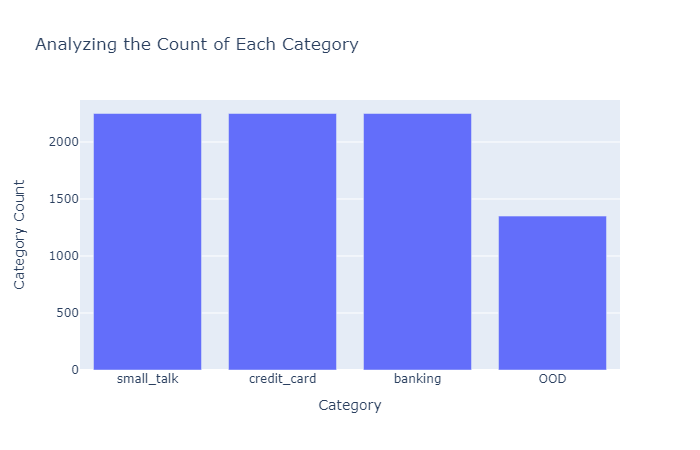

In [7]:
#plotting a bar graph displaying the category and count for each category to see if the data is balanced
cett_data_category_count=pd.DataFrame(cett_data.groupby('category').size().sort_values(ascending=False).rename('category_count').reset_index())
fig = px.bar(cett_data_category_count, x='category', y='category_count',
             labels={
                     "category": "Category",
                     "category_count": "Category Count"
                 },
              title='Analyzing the Count of Each Category ')
fig.show("png")

In [8]:
#Creating data frames consisting of intent and its count for each category
banking_data=cett_data.loc[cett_data['category'] == 'banking']
banking_data=pd.DataFrame(banking_data.groupby('intent').size().sort_values(ascending=False).rename('banking_intent_count').reset_index())
credit_card_data=cett_data.loc[cett_data['category'] == 'credit_card']
credit_card_data=pd.DataFrame(credit_card_data.groupby('intent').size().sort_values(ascending=False).rename('credit_card_data_count').reset_index())
small_talk_data=cett_data.loc[cett_data['category'] == 'small_talk']
small_talk_data=pd.DataFrame(small_talk_data.groupby('intent').size().sort_values(ascending=False).rename('small_talk_data_count').reset_index())

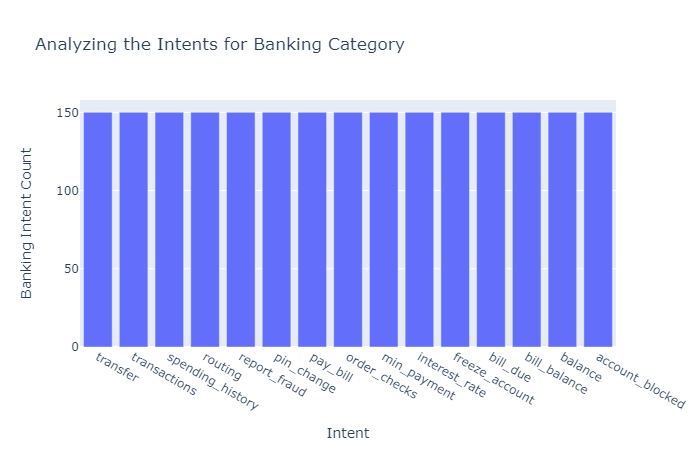

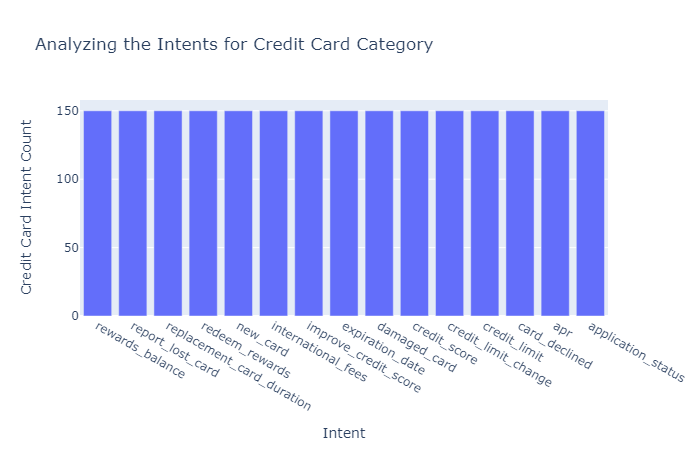

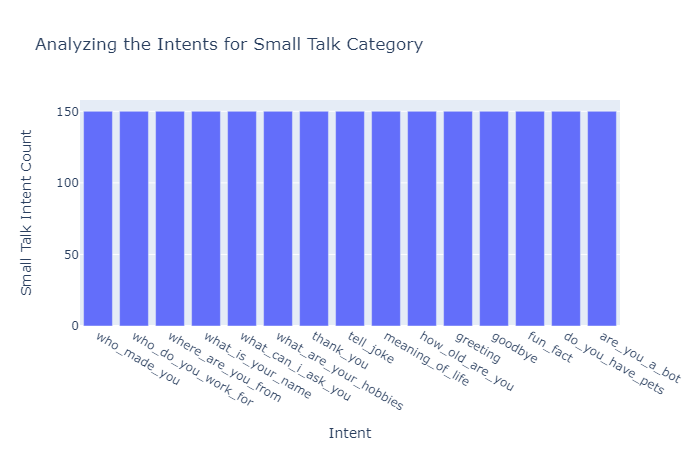

In [9]:
#plotting a bar graph to see the intent and its count for banking category
fig = px.bar(banking_data, x='intent', y='banking_intent_count',
             labels={
                     "intent": "Intent",
                     "banking_intent_count": "Banking Intent Count"
                 },
              title='Analyzing the Intents for Banking Category')
fig.show("png")
#plotting a bar graph to see the intent and its count for credit_card category
fig = px.bar(credit_card_data, x='intent', y='credit_card_data_count',
             labels={
                     "intent": "Intent",
                     "credit_card_data_count": "Credit Card Intent Count"
                 },
              title='Analyzing the Intents for Credit Card Category')
fig.show("png")
#plotting a bar graph to see the intent and its count for small_talk category
fig = px.bar(small_talk_data, x='intent', y='small_talk_data_count',
             labels={
                     "intent": "Intent",
                     "small_talk_data_count": "Small Talk Intent Count"
                 },
              title='Analyzing the Intents for Small Talk Category ')
fig.show("png")

# Data Preprocessing and Word Token Analysis
In the below blocks of code, the data is being pre-processed. The text column is used for data preprocessing. Following steps are applied for preprocessing
1) The text is converted to lower case.

2) Digits and special symbols are removed from the text.

3) The text is pre-processed to remove the stop words.

4) A new column named clean_data is created to store the pre-processed data.

<br>


Word Cloud is used the analyze the text for each category. From the visualized word cloud we can conclude the following things:
1) In the banking category the common words used are related to checking the amount, routing numbers, bills, payments, and interests.

2) In the credit_card category the words are related to the credit card limits, rewards, credit score, and queries regarding card lost or declined.

3) The small_talk category involved questions related to the meaning of life, pets, facts, and humans.

4) The OOD category includes everything which is not related to any of the above-mentioned categories and tends to have things related to cars and phones.



In [9]:
#function the pre-process the input text. Removes digits, stop words, special symbols and converts the text to lower case.
#input: the 'text' column of the dataframe
#output: A lower case string with no stop words, digits and special symbols
def clean_text(text):
    """Cleans the given text to remove stop words, digits and special symbols
    
    Args:
        text (String): Input string to preprocess
        
    Returns:
        String: Cleaned text
    """
    cleaned_text=[]
    stop_words=stopwords.words('english')
    
    for sent in text:
        text=sent.lower()
        text = re.sub(r'\d+', '', text.lower())
        word_tokenizer = nltk.RegexpTokenizer(r"\w+")
        tokenized_text = word_tokenizer.tokenize(text)
        processed_text = [word for word in tokenized_text if word.lower() not in stopwords.words('english')]
        string = " ".join(processed_text)
        cleaned_text.append(string)
        
    return cleaned_text

In [10]:
#call to the clean_text function
tokenized_Data=clean_text(cett_data['text'])

#adding a new column named clean_data which will hold the pre-processed data for each row.
cett_data['clean_data']=pd.Series(tokenized_Data)

print("Data Frame containing the new column clean_data which hold the pre-processed data")
cett_data.head()

Data Frame containing the new column clean_data which hold the pre-processed data


,text,intent,category,split,clean_data
0,i need more checkbooks for my chase account,order_checks,banking,train,need checkbooks chase account
1,is my card's apr a decent rate,apr,credit_card,test,card apr decent rate
2,tell me the bill's minimum payment,min_payment,banking,train,tell bill minimum payment
3,what does life mean to you,meaning_of_life,small_talk,train,life mean
4,do you have a preference regarding what i shou...,what_is_your_name,small_talk,train,preference regarding call


(-0.5, 999.5, 599.5, -0.5)

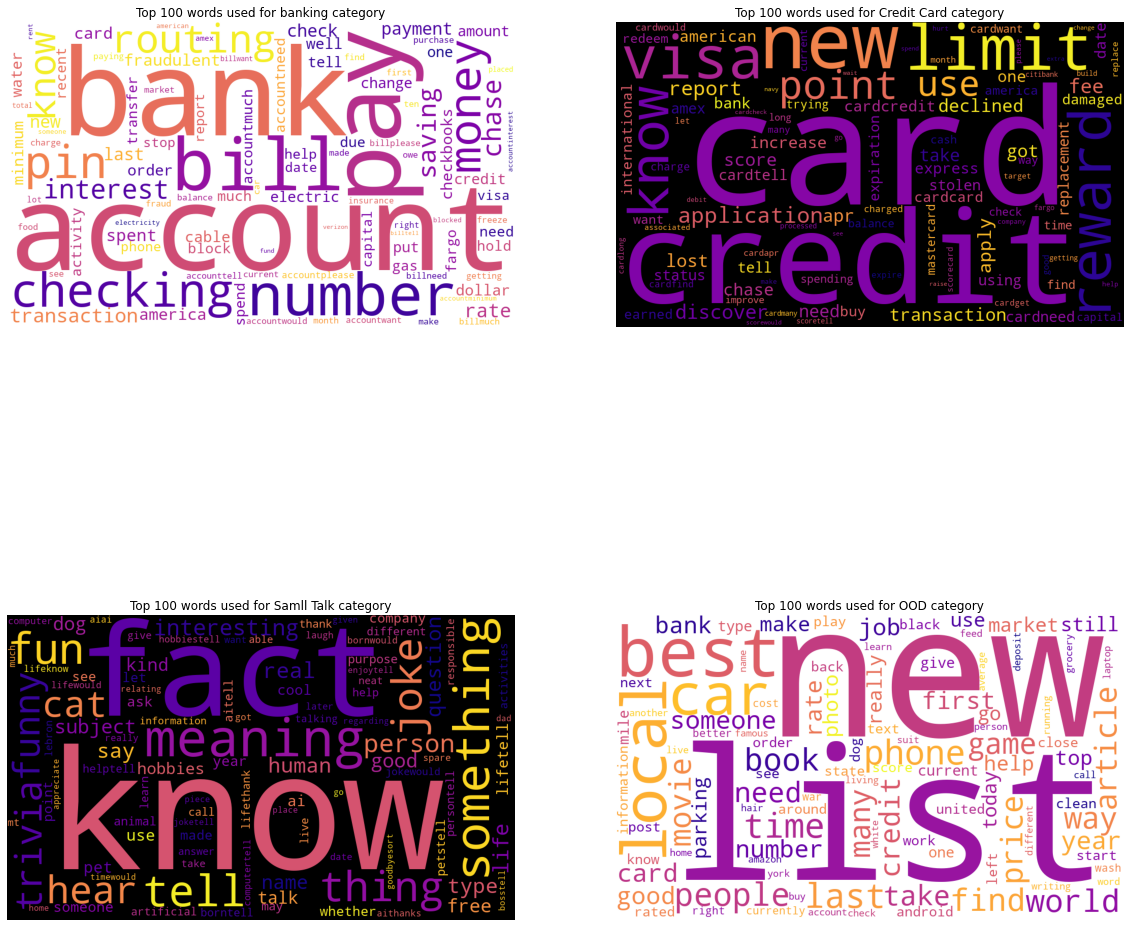

In [11]:
#creating subplots to plot 4 word cloud visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,20))

#creating word cloud for each category with 100 words 
wordcloud_bank = WordCloud(width=1000,height=600, background_color='white',colormap='plasma', max_words=100, collocations=False).generate( "".join(list(cett_data[cett_data['category']=='banking']['clean_data'].values)))
wordcloud_credit = WordCloud(width=1000,height=600, background_color='black',colormap='plasma', max_words=100, collocations=False).generate( "".join(list(cett_data[cett_data['category']=='credit_card']['clean_data'].values)))
wordcloud_small_talk = WordCloud(width=1000,height=600, background_color='black',colormap='plasma', max_words=100, collocations=False).generate( "".join(list(cett_data[cett_data['category']=='small_talk']['clean_data'].values)))
wordcloud_OOD = WordCloud(width=1000,height=600, background_color='white',colormap='plasma', max_words=100, collocations=False).generate( "".join(list(cett_data[cett_data['category']=='OOD']['clean_data'].values)))

#plotting word cloud for banking category
ax1.set_title('Top 100 words used for banking category')
ax1.imshow(wordcloud_bank)
ax1.axis('off')

#plotting word cloud for credit category category
ax2.set_title('Top 100 words used for Credit Card category')
ax2.imshow(wordcloud_credit)
ax2.axis('off')

#plotting word cloud for Small talk category
ax3.set_title('Top 100 words used for Samll Talk category')
ax3.imshow(wordcloud_small_talk)
ax3.axis('off')

#plotting word cloud for OOD category
ax4.set_title('Top 100 words used for OOD category')
ax4.imshow(wordcloud_OOD)
ax4.axis('off')

# Displaying top 20 words used in the text column

The following block of code is used to analyze the top words that are encountered in the text. It gives us idea about what mostly the people tend to ask. From the graph it is observed that top 20 words are related to the banking and credit_card .

In [12]:
word_tokenizer_freq = nltk.RegexpTokenizer(r"\w+")

#tokenizing the text
tokenized_tweets_freq = word_tokenizer_freq.tokenize("".join(list(cett_data['clean_data'].values)))

#calculating the frequency of the tokens 
freq_dist =nltk.FreqDist(tokenized_tweets_freq)

#storing the most common 20 words
freq_list = freq_dist.most_common(20)
freq_list

[('card', 944),
 ('credit', 917),
 ('know', 360),
 ('bank', 350),
 ('account', 311),
 ('new', 264),
 ('pay', 197),
 ('get', 188),
 ('visa', 177),
 ('number', 165),
 ('limit', 162),
 ('like', 157),
 ('bill', 148),
 ('chase', 144),
 ('checking', 131),
 ('tell', 127),
 ('pin', 126),
 ('money', 124),
 ('routing', 116),
 ('rewards', 112)]

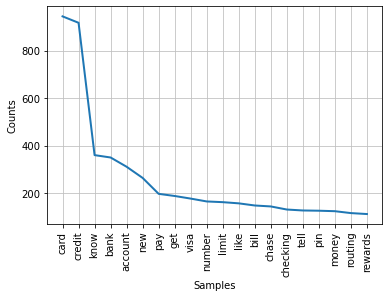

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [13]:
#plotting the top 20 words 
freq_dist.plot(20)

# Splitting the data into train and test Datasets 

In [14]:
#filtering the data based on the split column
train_data=cett_data.loc[cett_data['split'] == 'train']
test_data=cett_data.loc[cett_data['split'] == 'test']

In [15]:
#X_train contains the data for training the model
X_train=train_data['clean_data'] 

#y_train contains the labels for the train data 
y_train=train_data['category']

#X_test contains the data used for testing on the the trained models
X_test=test_data['clean_data']

#y_test contains the true categories of the test data
y_test=test_data['category']

In [16]:
#number of records in the training dataset 
print(len(X_train))
print(len(y_train))

6400
6400


In [17]:
#number of records in the test dataste
print(len(X_test))
print(len(y_test))

1700
1700


# Functions used for Model Training and Prediction
I have formulated 2 solutions for the classification problem. the dataset has intent and categories and the model needs to predict both the columns. I have used Multinomial Naive Bayes and Support Vector Classifier for classification. The performance of the Multinomial Naive Bayes classifier and Support Vector Classifier is compared using accuracy, classification report, and the processing time required for training the models.
<br> <br><br> <br>
The first solution uses a stacked approach which consist of the following steps:
1) Developing a Multinomial Naive Bayes classifier which is trained for predicting the category

2) Filtering the data for each category and then splitting it into train and test datasets

3) Developing Multinomial Naive Bayes classifier for each of the category types which will be used for predicting the intent

4) Using the  model to predict the category and then based on the category predicted using the category-specific model to predict the intent for the category

Similar steps are followed by using the Support Vector Classifier as well.
<br> <br><br> <br>
The second solution uses a single model approach which consist of the following steps:

1) Creating a dictionary consisting of the mapping between the category and its intents

2) Developing a Multinomial Naive Bayes for predicting the intent directly on the full dataset

3) Iterating through the dictionary to get the category for the predicted intent

Similar steps are followed by using the Support Vector Classifier as well.


In [18]:
#Funtion to create taining and test data for model training for each category
#Input: The entire dataste and the keyword.Keyword is the category from the dataset
#Output: The category specific train and test datasets
def create_category_data(keyword,cett_data):
    """This function creates the train and test data for individual category
    
    Args:
        keyword (String): Input category for filtering
        cett_data (pandas dataframe): Input dataframe
        
    Returns:
        X_train_category (pandas dataframe): Training features for individual category
        y_train_category (pandas dataframe): Training target for individual category
        X_test_category (pandas dataframe): Testing features for individual category
        y_test_category (pandas dataframe): Testing target for individual category
    """
    category_data=cett_data.loc[cett_data['category'] == keyword]
    train_category_data=category_data.loc[category_data['split'] == 'train']
    test_category_data=category_data.loc[category_data['split'] == 'test']
    X_train_category=train_category_data['clean_data']
    y_train_category=train_category_data['intent']
    X_test_category=test_category_data['clean_data']
    y_test_category=test_category_data['intent']
    
    return X_train_category, y_train_category, X_test_category, y_test_category

In [19]:
#funtion to pre-process the user input while predicting 
#Input: User Input
#Output: Pre-processed text.
def clean_text_userinput(text):
    """funtion to pre-process the user input while predicting
    """
    text=text.lower()
    text = re.sub(r'\d+', '', text.lower())
    word_tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokenized_text = word_tokenizer.tokenize(text)
    processed_text = [word for word in tokenized_text if word.lower() not in stopwords.words('english')]
    string = " ".join(processed_text)
    
    return string

In [20]:
#Function Used for developing the multinomial Naive Bayes Algorithm along with pipeline to develop features
#and hyper-parameter tuning
#Input: Training data and labels 
#Output: Trained multinomial naives Bayes Algorithm
def model_train_multiNB(X_train,y_train):
    """Trains the multinomial Naive Bayes algorithm on given training data
    
    Args:
        X_train (pandas dataframe): Training features
        y_train (pandas dataframe): Training target
    
    Returns:
        Multinomial Naive Bayes model object
    """
    text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
    
    tuned_parameters = {
   'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2],
    'clf__fit_prior': [True, False]
    }
    
    clf_multiNB = GridSearchCV(text_clf, tuned_parameters, cv=5)
    clf_multiNB.fit(X_train, y_train)
    
    return clf_multiNB

In [21]:
#Function Used for developing the Support Vector Classifier Algorithm along with pipeline to develop features
#and hyper-parameter tuning
#Input: Training data and labels 
#Output: Trained Support Vector Classifier Algorithm
def model_train_SVC(X_train,y_train):
    """Trains the SVC algorithm on given training data
    
    Args:
        X_train (pandas dataframe): Training features
        y_train (pandas dataframe): Training target
    
    Returns:
        SVC model object
    """
    text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC())])
    
    tuned_parameters = {
   'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
    }
    
    model_svm = GridSearchCV(text_clf, tuned_parameters, cv=5)
    model_svm.fit(X_train, y_train)
    
    return model_svm 

In [22]:
#Funtion to calculate various performance measures
#Input: The trained model, test data and labels
#Output: The best parameters from hyper parameter tuninig, model accuracy, classification report and confusion matrix 

def calculate_acccuracy_metrics(model,X_test,y_test):
    """Calculates accuracy metrics with given model object and test data
    
    Args:
        model: model object
        X_test (pandas dataframe): Test features
        y_test (pandas dataframe): Test target
    """
    best_parameters=model.best_params_
    classification_metrics=classification_report(y_test, model.predict(X_test), digits=4)
    y_pred_class = model.predict((X_test))
    accuracy=accuracy_score(y_test, y_pred_class)
    model_confusion_matrix=confusion_matrix(y_test,y_pred_class)
    
    return best_parameters, accuracy, classification_metrics,model_confusion_matrix
                                

In [23]:
#Funtion to give the category or intent prediction
#Input: The input data and the trained model
#Output: The category or intent predicted by the trained model 

def predict(input_data,model):
    """Return the predicted output for input and model given
    """
    
    input_data=clean_text_userinput(input_data)
    
    return model.predict([input_data])[0]
    

In [24]:
#Funtion to predict the category based on the user input. Then considering the category using the category specific trained
#models to predict the intent.
#Input: The input from the user
#Output: The predicted category and intent 
def category_based_intent_prediction(user_input):
    """Predicts the intent and category with given user input
    """
    user_input=clean_text_userinput(user_input)
    predicted_category=predict(user_input,category_model_svc)
    predicted_intent=''
    
    if(predicted_category=='banking'):
        predicted_intent=predict(user_input,model_svc_banking)
    elif(predicted_category=='credit_card'):
        predicted_intent=predict(user_input,model_svc_credit)
    elif(predicted_category=='small_talk'):
        predicted_intent=predict(user_input,model_svc_st)
    elif(predicted_category=='OOD'):
        predicted_intent='OOD'
        
    return predicted_category, predicted_intent

In [25]:
#Funtion to predict the intent on the input provided from the user and then iterating the dictionary to find the category
#Input: Input from the user and the trained model
#Output: The predicted category and intent 
def predict_intent(user_input,model):
    """Predicts the intent and category with given user input
    """
    predicted_category=''
    input_data=clean_text_userinput(user_input)
    input_data=''.join(input_data)
    
    predicted_intent=predict(input_data,model)
    
    if(predicted_intent=='OOD'):
        predicted_category="OOD"
        return predicted_category,predicted_intent
    
    for key in category_intent_dict:
        if predicted_intent in category_intent_dict[key]:
            predicted_category=key
            
            return predicted_category,predicted_intent
        

# Model Training and Prediction: Stacked Approach


In [26]:
#Training the Multinomial Naive Bayes classifier for predicting the category
print('******* Category Prediction Using Multinomial Naive Bayes ********')

start_time = time.time()
model_multiNB=model_train_multiNB(X_train,y_train)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))

best_parameters_NB, accuracy_NB, classification_metric_NB,confusion_matrix_NB=calculate_acccuracy_metrics(model_multiNB,X_test,y_test)

print('The best parameters for the model:',best_parameters_NB)
print("Highest avg. Accuracy observed during cross validation:",model_multiNB.best_score_*100)
print('Multinomial Naive Bayes Accuracy:',accuracy_NB*100)
print('Multinomial Naive Bayes Classification Report:')
print(classification_metric_NB)
print('Multinomial Naive Bayes Confusion Matrix:')
print(confusion_matrix_NB)

******* Category Prediction Using Multinomial Naive Bayes ********
---Processing Time is 26.645259141921997 seconds ---
The best parameters for the model: {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Highest avg. Accuracy observed during cross validation: 93.76562500000001
Multinomial Naive Bayes Accuracy: 90.88235294117646
Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

         OOD     0.8945    0.7029    0.7872       350
     banking     0.9070    0.9533    0.9296       450
 credit_card     0.9198    0.9933    0.9551       450
  small_talk     0.9077    0.9400    0.9236       450

    accuracy                         0.9088      1700
   macro avg     0.9073    0.8974    0.8989      1700
weighted avg     0.9080    0.9088    0.9054      1700

Multinomial Naive Bayes Confusion Matrix:
[[246  38  25  41]
 [  8 429  11   2]
 [  1   2 447   0]
 [ 20   4   3 423

In [27]:
#Predicting the category by using the  Multinomial Naive Bayes  trained model
category=predict('Pandemic is making life stressful',model_multiNB)
print("The predicted category is:",category)

The predicted category is: small_talk


In [28]:
#Training the Multinomial Naive Bayes classifier for predicting the intent for banking category
print('******* Intent Prediction for Banking Category using Multinomial Naive Bayes ********')
X_train_bank, y_train_bank, X_test_bank, y_test_bank=create_category_data('banking',cett_data)
start_time = time.time()
model_multiNB_banking=model_train_multiNB(X_train_bank,y_train_bank)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_bank, accuracy_bank, classification_metric_bank,confusion_matrix_bank=calculate_acccuracy_metrics(model_multiNB_banking,X_test_bank,y_test_bank)
print('The best parameters for the model:',best_parameters_bank)
print("Highest avg. Accuracy observed during cross validation:",model_multiNB_banking.best_score_*100)
print('Multinomial Naive Bayes Accuracy:',accuracy_bank*100)
print('Multinomial Naive Bayes Classification Report:')
print(classification_metric_bank)
print('Multinomial Naive Bayes Confusion Matrix:')
print(confusion_matrix_bank)

******* Intent Prediction for Banking Category using Multinomial Naive Bayes ********
---Processing Time is 9.335975170135498 seconds ---
The best parameters for the model: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 92.66666666666666
Multinomial Naive Bayes Accuracy: 88.66666666666667
Multinomial Naive Bayes Classification Report:
                  precision    recall  f1-score   support

 account_blocked     0.7500    0.8000    0.7742        30
         balance     0.8846    0.7667    0.8214        30
    bill_balance     0.9259    0.8333    0.8772        30
        bill_due     0.7105    0.9000    0.7941        30
  freeze_account     0.8966    0.8667    0.8814        30
   interest_rate     1.0000    0.9667    0.9831        30
     min_payment     0.8788    0.9667    0.9206        30
    order_checks     0.9677    1.0000    0.9836        30
        pay_

In [29]:
#Predicting the intent of banking category by using the  Multinomial Naive Bayes trained model
predicted_banking_intent=predict('tell the balance',model_multiNB_banking)
print("Predicted Banking Intent:",predicted_banking_intent)

Predicted Banking Intent: balance


In [30]:
#Training the Multinomial Naive Bayes classifier for predicting the intent for credit_card category
print('******* Intent Prediction for credit_card Category using Multinomial Naive Bayes ********')
X_train_credit, y_train_credit, X_test_credit, y_test_credit=create_category_data('credit_card',cett_data)
start_time = time.time()
model_multiNB_credit=model_train_multiNB(X_train_credit,y_train_credit)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_credit, accuracy_credit, classification_metric_credit,confusion_matrix_credit=calculate_acccuracy_metrics(model_multiNB_credit,X_test_credit,y_test_credit)
print('The best parameters for the model:',best_parameters_credit)
print("Highest avg. Accuracy observed during cross validation:",model_multiNB_credit.best_score_*100)
print('Multinomial Naive Bayes Accuracy:',accuracy_credit*100)
print('Multinomial Naive Bayes Classification Report:')
print(classification_metric_credit)
print('Multinomial Naive Bayes Confusion Matrix:')
print(confusion_matrix_credit)

******* Intent Prediction for credit_card Category using Multinomial Naive Bayes ********
---Processing Time is 9.029158115386963 seconds ---
The best parameters for the model: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 94.27777777777777
Multinomial Naive Bayes Accuracy: 89.33333333333333
Multinomial Naive Bayes Classification Report:
                           precision    recall  f1-score   support

       application_status     1.0000    1.0000    1.0000        30
                      apr     0.8824    1.0000    0.9375        30
            card_declined     1.0000    0.8000    0.8889        30
             credit_limit     0.9000    0.9000    0.9000        30
      credit_limit_change     0.9355    0.9667    0.9508        30
             credit_score     0.8235    0.9333    0.8750        30
             damaged_card     0.8788    0.9667    0.9206     

In [31]:
#Predicting the intent of credit_card category by using the  Multinomial Naive Bayes trained model
predicted_credit_card_intent=predict('what is my credit card limit',model_multiNB_credit)
print("Predicted intent for credit_card category:",predicted_credit_card_intent)

Predicted intent for credit_card category: credit_limit


In [32]:
#Training the Multinomial Naive Bayes classifier for predicting the intent for small_talk category
print('******* Intent Prediction for small_talk Category using Multinomial Naive Bayes ********')
X_train_small_talk, y_train_small_talk, X_test_small_talk, y_test_small_talk=create_category_data('small_talk',cett_data)
start_time = time.time()
model_multiNB_st=model_train_multiNB(X_train_small_talk,y_train_small_talk)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_st, accuracy_st, classification_metric_st,confusion_matrix_st=calculate_acccuracy_metrics(model_multiNB_st,X_test_small_talk,y_test_small_talk)
print('The best parameters for the model:',best_parameters_st)
print("Highest avg. Accuracy observed during cross validation:",model_multiNB_st.best_score_*100)
print('Multinomial Naive Bayes Accuracy:',accuracy_st*100)
print('Multinomial Naive Bayes Classification Report:')
print(classification_metric_st)
print('Multinomial Naive Bayes Confusion Matrix:')
print(confusion_matrix_st)

******* Intent Prediction for small_talk Category using Multinomial Naive Bayes ********
---Processing Time is 7.0627241134643555 seconds ---
The best parameters for the model: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Highest avg. Accuracy observed during cross validation: 88.1111111111111
Multinomial Naive Bayes Accuracy: 87.77777777777777
Multinomial Naive Bayes Classification Report:
                       precision    recall  f1-score   support

        are_you_a_bot     0.6122    1.0000    0.7595        30
     do_you_have_pets     1.0000    1.0000    1.0000        30
             fun_fact     1.0000    0.9333    0.9655        30
              goodbye     0.8667    0.8667    0.8667        30
             greeting     0.9167    0.7333    0.8148        30
      how_old_are_you     0.8966    0.8667    0.8814        30
      meaning_of_life     0.9355    0.9667    0.9508        30
            tell_joke     0.

In [33]:
#Predicting the intent of small_talk category by using the  Multinomial Naive Bayes trained model
predicted_small_talk_category=predict('Life is short',model_multiNB_st)
print("Predicted intent for small_talk category:",predicted_small_talk_category)

Predicted intent for small_talk category: meaning_of_life


In [34]:
#Training the Support Vector Classifier  for predicting the category
print('******* Category Prediction Using Support Vector Classifier ********')
start_time = time.time()
category_model_svc=model_train_SVC(X_train,y_train)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_svc, accuracy_svc, classification_metric_svc,confusion_matrix_svc=calculate_acccuracy_metrics(category_model_svc,X_test,y_test)
print('The best parameters for the model:',best_parameters_svc)
print("Highest avg. Accuracy observed during cross validation:",category_model_svc.best_score_*100)
print('Support Vector Calssifier Accuracy:',accuracy_svc*100)
print('Support Vector Calssifier Classification Report:')
print(classification_metric_svc)
print('Support Vector Calssifier Confusion Matrix:')
print(confusion_matrix_svc)

******* Category Prediction Using Support Vector Classifier ********
---Processing Time is 102.77689576148987 seconds ---
The best parameters for the model: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 95.625
Support Vector Calssifier Accuracy: 91.64705882352942
Support Vector Calssifier Classification Report:
              precision    recall  f1-score   support

         OOD     0.9029    0.7171    0.7994       350
     banking     0.9595    0.9467    0.9530       450
 credit_card     0.9670    0.9778    0.9724       450
  small_talk     0.8432    0.9800    0.9065       450

    accuracy                         0.9165      1700
   macro avg     0.9181    0.9054    0.9078      1700
weighted avg     0.9190    0.9165    0.9142      1700

Support Vector Calssifier Confusion Matrix:
[[251  15   7  77]
 [ 15 426   7   2]
 [  5   2 440   3]
 [  7   1   1 441]]


In [35]:
#Predicting the category by using the Support Vector Classifier trained model
category_SVC=predict('Man is standing',category_model_svc)
print("The predicted category is:",category_SVC)

The predicted category is: OOD


In [36]:
#Training theSupport Vector Classifier classifier for predicting the intent for banking category
print('******* Intent Prediction for Banking Category using Support Vector Classifier ********')
start_time = time.time()
model_svc_banking=model_train_SVC(X_train_bank,y_train_bank)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_bank_svc, accuracy_bank_svc, classification_metric_bank_svc,confusion_matrix_bank_svc=calculate_acccuracy_metrics(model_svc_banking,X_test_bank,y_test_bank)
print('The best parameters for the model:',best_parameters_bank_svc)
print("Highest avg. Accuracy observed during cross validation:",model_svc_banking.best_score_*100)
print('Support Vector Calssifier Accuracy:',accuracy_bank_svc*100)
print('Support Vector Calssifier Classification Report:')
print(classification_metric_bank_svc)
print('Support Vector Calssifier Confusion Matrix:')
print(confusion_matrix_bank_svc)

******* Intent Prediction for Banking Category using Support Vector Classifier ********
---Processing Time is 15.181061267852783 seconds ---
The best parameters for the model: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 93.16666666666666
Support Vector Calssifier Accuracy: 88.44444444444444
Support Vector Calssifier Classification Report:
                  precision    recall  f1-score   support

 account_blocked     0.6842    0.8667    0.7647        30
         balance     0.8750    0.9333    0.9032        30
    bill_balance     0.8929    0.8333    0.8621        30
        bill_due     0.7879    0.8667    0.8254        30
  freeze_account     0.8846    0.7667    0.8214        30
   interest_rate     1.0000    0.9667    0.9831        30
     min_payment     0.9667    0.9667    0.9667        30
    order_checks     1.0000    1.0000    1.0000        30
        pay_bill     0.8889    0.8000    0.8421  

In [37]:
#Predicting the intent of banking category by using the Support Vector classifier trained model
predicted_banking_intent_svc=predict('tell the balance',model_svc_banking)
print("Predicted Banking Intent:",predicted_banking_intent_svc)

Predicted Banking Intent: balance


In [38]:
#Training the Support Vector classifier for predicting the intent for credit_card category
print('******* Intent Prediction for credit_card Category using Support Vector Classifier ********')
start_time = time.time()
model_svc_credit=model_train_SVC(X_train_credit,y_train_credit)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_credit_svc, accuracy_credit_svc, classification_metric_credit_svc,confusion_matrix_credit_svc=calculate_acccuracy_metrics(model_svc_credit,X_test_credit,y_test_credit)
print('The best parameters for the model:',best_parameters_credit_svc)
print("Highest avg. Accuracy observed during cross validation:",model_svc_credit.best_score_*100)
print('Support Vector Calssifier Accuracy:',accuracy_credit_svc*100)
print('Support Vector Calssifier Classification Report:')
print(classification_metric_credit_svc)
print('Support Vector Calssifier Confusion Matrix:')
print(confusion_matrix_credit_svc)

******* Intent Prediction for credit_card Category using Support Vector Classifier ********
---Processing Time is 14.274828672409058 seconds ---
The best parameters for the model: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 94.72222222222223
Support Vector Calssifier Accuracy: 90.22222222222223
Support Vector Calssifier Classification Report:
                           precision    recall  f1-score   support

       application_status     1.0000    1.0000    1.0000        30
                      apr     1.0000    1.0000    1.0000        30
            card_declined     1.0000    0.7667    0.8679        30
             credit_limit     0.9355    0.9667    0.9508        30
      credit_limit_change     1.0000    0.9333    0.9655        30
             credit_score     0.7368    0.9333    0.8235        30
             damaged_card     0.7143    1.0000    0.8333        30
          expiration_date     1

In [39]:
#Predicting the intent of credit_card category by using the Support Vector classifier trained model
predicted_credit_card_intent_svc=predict('what is my credit card limit',model_svc_credit)
print("Predicted intent for credit_card category:",predicted_credit_card_intent_svc)

Predicted intent for credit_card category: credit_limit


In [40]:
#Training the Support Vector Classifier classifier for predicting the intent for small_talk category
print('******* Intent Prediction for small_talk Category using Support Vector Classifier********')
start_time = time.time()
model_svc_st=model_train_SVC(X_train_small_talk,y_train_small_talk)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_st_svc, accuracy_st_svc, classification_metric_st_svc,confusion_matrix_st_svc=calculate_acccuracy_metrics(model_svc_st,X_test_small_talk,y_test_small_talk)
print('The best parameters for the model:',best_parameters_st_svc)
print("Highest avg. Accuracy observed during cross validation:",model_svc_st.best_score_*100)
print('Support Vector Calssifier Accuracy:',accuracy_st_svc*100)
print('Support Vector Calssifier Classification Report:')
print(classification_metric_st_svc)
print('Support Vector Calssifier Confusion Matrix:')
print(confusion_matrix_st_svc)

******* Intent Prediction for small_talk Category using Support Vector Classifier********
---Processing Time is 10.036449432373047 seconds ---
The best parameters for the model: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 88.33333333333331
Support Vector Calssifier Accuracy: 89.33333333333333
Support Vector Calssifier Classification Report:
                       precision    recall  f1-score   support

        are_you_a_bot     1.0000    1.0000    1.0000        30
     do_you_have_pets     1.0000    1.0000    1.0000        30
             fun_fact     1.0000    0.9667    0.9831        30
              goodbye     0.8519    0.7667    0.8070        30
             greeting     0.5200    0.8667    0.6500        30
      how_old_are_you     1.0000    0.9000    0.9474        30
      meaning_of_life     1.0000    0.9333    0.9655        30
            tell_joke     1.0000    1.0000    1.0000        30
  

In [41]:
#Predicting the intent of small_talk category by using the Support Vector classifier trained model
predicted_small_talk_category=predict('Life is short',model_svc_st)
print("Predicted intent for small_talk category:",predicted_small_talk_category)

Predicted intent for small_talk category: meaning_of_life


# Using the Trained models for predicting the category and intent on the user input
Multinomial Naive Bayes and Support Vector Classifier is used for model training. The Support Vector Classifier achieved greater accuracy during cross-validation and on the test data as well when compared to the Multinomial Naive Bayes Classifier. This is evident for the category classification as well as the category-specific intent classification. The precision has improved significantly with the Support Vector Classifier. Therefore for prediction on the user input, I have used Support Vector Classifier.

In [42]:
category, intent=category_based_intent_prediction('let us go out')
print("The predicted category is:",category)
print("The predicted intent is:",intent)

The predicted category is: small_talk
The predicted intent is: where_are_you_from


In [43]:
category, intent=category_based_intent_prediction('how to open a new account')
print("The predicted category is:",category)
print("The predicted intent is:",intent)

The predicted category is: banking
The predicted intent is: balance


In [44]:
category, intent=category_based_intent_prediction('will i get any bonus points')
print("The predicted category is:",category)
print("The predicted intent is:",intent)

The predicted category is: credit_card
The predicted intent is: redeem_rewards


# Model Training and Prediction: Single Model Approach

In [45]:
#Splitting the data into test and train when intent is the target label

#X_train_intent contains the data used for training the model
X_train_intent=train_data['clean_data']

#y_train_intent contains the labels 
y_train_intent=train_data['intent']

#X_test_intent contains the data used for testing the model
X_test_intent=test_data['clean_data']

#y_test_intent contains the true values of labels 
y_test_intent=test_data['intent']

In [46]:
#filtering the unique values and storing in a list for all the categories 
bank_data=cett_data.loc[cett_data['category'] == 'banking']
unique_bank_intent=bank_data.intent.unique()
credit_data=cett_data.loc[cett_data['category'] == 'credit_card']
unique_credit_data_intent=credit_data.intent.unique()
st_data=cett_data.loc[cett_data['category'] == 'small_talk']
unique_st_data_intent=st_data.intent.unique()

In [47]:
#Creating a dictionary that stores the mapping of categories and its intents 
category_intent_dict={}
category_intent_dict['banking']=unique_bank_intent
category_intent_dict['credit_card']=unique_credit_data_intent
category_intent_dict['small_talk']=unique_st_data_intent
category_intent_dict

{'banking': array(['order_checks', 'min_payment', 'account_blocked', 'routing',
        'balance', 'transactions', 'pay_bill', 'spending_history',
        'report_fraud', 'bill_due', 'transfer', 'bill_balance',
        'pin_change', 'freeze_account', 'interest_rate'], dtype=object),
 'credit_card': array(['apr', 'improve_credit_score', 'application_status',
        'credit_score', 'international_fees', 'replacement_card_duration',
        'rewards_balance', 'card_declined', 'report_lost_card',
        'expiration_date', 'credit_limit_change', 'redeem_rewards',
        'credit_limit', 'new_card', 'damaged_card'], dtype=object),
 'small_talk': array(['meaning_of_life', 'what_is_your_name', 'who_made_you', 'fun_fact',
        'who_do_you_work_for', 'what_are_your_hobbies', 'thank_you',
        'what_can_i_ask_you', 'greeting', 'goodbye', 'tell_joke',
        'are_you_a_bot', 'do_you_have_pets', 'how_old_are_you',
        'where_are_you_from'], dtype=object)}

In [48]:
#Training the Multinomial Naive Bayes for predicting the intent
print('******* Intent Prediction using Multinomial Naive Bayes ********')
start_time = time.time()
model_multiNB_intent=model_train_multiNB(X_train_intent,y_train_intent)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_NB_intent, accuracy_NB_intent, classification_metric_NB_intent,confusion_matrix_NB_intent=calculate_acccuracy_metrics(model_multiNB_intent,X_test_intent,y_test_intent)
print('The best parameters for the model:',best_parameters_NB_intent)
print("Highest avg. Accuracy observed during cross validation:",model_multiNB_intent.best_score_*100)
print('Multinomial Naive Bayes Accuracy:',accuracy_NB_intent*100)
print('Multinomial Naive Bayes Classification Report:')
print(classification_metric_NB_intent)
print('Multinomial Naive Bayes Confusion Matrix:')
print(confusion_matrix_NB_intent)

******* Intent Prediction using Multinomial Naive Bayes ********
---Processing Time is 34.47626852989197 seconds ---
The best parameters for the model: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 88.56250000000001
Multinomial Naive Bayes Accuracy: 83.58823529411765
Multinomial Naive Bayes Classification Report:
                           precision    recall  f1-score   support

                      OOD     0.7938    0.7371    0.7644       350
          account_blocked     0.7667    0.7667    0.7667        30
       application_status     0.9091    1.0000    0.9524        30
                      apr     0.9062    0.9667    0.9355        30
            are_you_a_bot     0.8824    1.0000    0.9375        30
                  balance     0.9286    0.8667    0.8966        30
             bill_balance     0.8148    0.7333    0.7719        30
                 bil

In [49]:
#predicitng the intent using the trained Multinomial Naive Bayes model
print(predict('Life is short',model_multiNB_intent))

meaning_of_life


In [50]:
#Training the Support Vector Classifier for predicting the intent
print('******* Intent Prediction using Support Vector Classifier ********')
start_time = time.time()
SVC_intent_model=model_train_SVC(X_train_intent,y_train_intent)
print("---Processing Time is %s seconds ---" % (time.time() - start_time))
best_parameters_svc_intent, accuracy_svc_intent, classification_metric_svc_intent,confusion_matrix_svc_intent=calculate_acccuracy_metrics(SVC_intent_model,X_test_intent,y_test_intent)
print('The best parameters for the model:',best_parameters_svc_intent)
print("Highest avg. Accuracy observed during cross validation:",SVC_intent_model.best_score_*100)
print('Support Vector Classifier Accuracy:',accuracy_svc_intent*100)
print('Support Vector Classifier Classification Report:')
print(classification_metric_svc_intent)
print('Support Vector Classifier Confusion Matrix:')
print(confusion_matrix_svc_intent)

******* Intent Prediction using Support Vector Classifier ********
---Processing Time is 230.41581797599792 seconds ---
The best parameters for the model: {'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
Highest avg. Accuracy observed during cross validation: 88.25
Support Vector Classifier Accuracy: 85.58823529411764
Support Vector Classifier Classification Report:
                           precision    recall  f1-score   support

                      OOD     0.7178    0.9086    0.8020       350
          account_blocked     0.7742    0.8000    0.7869        30
       application_status     0.9677    1.0000    0.9836        30
                      apr     0.9677    1.0000    0.9836        30
            are_you_a_bot     1.0000    0.9667    0.9831        30
                  balance     0.9310    0.9000    0.9153        30
             bill_balance     0.9565    0.7333    0.8302        30
                 bill_due     0.8065    0.8333    0.8197        30
 

# Predicting the Intent using the Single Model Approach 
For the intent prediction as well the Support Vector Classifier has performed well as compared to the multinomial Naive Bayes algorithm. So for prediction, the SVC model has been used. The intent is predicted using the model and then the dictionary is iterated to find the category mapped to the intent.

In [51]:
#predicting the category and intent using the trained model
predicted_category,predicted_intent =predict_intent('credit Card is blocked',SVC_intent_model)
print('predicted category:',predicted_category)
print('predicted intent:',predicted_intent)

predicted category: credit_card
predicted intent: damaged_card


In [52]:
#predicting the category and intent using the trained model
predicted_category,predicted_intent =predict_intent('I want to know about my rewards',SVC_intent_model)
print('predicted category:',predicted_category)
print('predicted intent:',predicted_intent)

predicted category: credit_card
predicted intent: rewards_balance


In [53]:
#predicting the category and intent using the trained model
predicted_category,predicted_intent =predict_intent('What is the balance?',SVC_intent_model)
print('predicted category:',predicted_category)
print('predicted intent:',predicted_intent)

predicted category: banking
predicted intent: balance


# Conclusion 

When the stacking and the dictionary approach are compared it is observed that the stacking approach has performed better as it has greater accuracy. Moreover, using the second approach it is difficult for the model to generalize over 46 classes. Considering the processing time, the stacking approach performed much better. Although processing time is not a concern as it can be improved by using cloud platforms for training the models. Considering the processing time and the performance metrics I would recommend using Support Vector Machine with the stacking approach.